# **Final working project**

### Explaination

For this analyses the code will look at a player stats in football, from these stat it can be deteriment if a player is a attacking threath or more defensive player.

Goalkeepers are removed from the data, this is because a fixed position in the field

### Imports


In [357]:
# Import all necessary libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Load the raw dataset
Raw_data = pd.read_csv('fifa_players.csv')

Raw_data.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


### Preperation

In [358]:
# First remove goalkeepers from the dataset, their positions are not relevant for this analysis
No_GK_data = Raw_data[~Raw_data['positions'].str.contains('GK', na=False)]

# Removing columns that are not relevant for the analysis
# positions is removed, because in the future we only have data for outfield players
Clean_data = No_GK_data.drop(['positions',"name","full_name","weak_foot(1-5)","overall_rating","skill_moves(1-5)","birth_date","age","height_cm","weight_kgs","nationality","potential","value_euro","wage_euro","international_reputation(1-5)","national_team_position","preferred_foot","body_type","release_clause_euro","national_team","national_rating","national_jersey_number"], axis=1) #Deleting raw data

In [359]:
# Define attacking and defending attributes
attacking_attributes = [
    'crossing', 'finishing', 'short_passing', 'volleys', 'dribbling', 
    'curve', 'freekick_accuracy', 'long_passing', 'ball_control', 
    'acceleration', 'sprint_speed', 'agility', 'positioning', 'vision', 
    'penalties', 'long_shots'
]

defending_attributes = [
    'heading_accuracy', 'jumping', 'stamina', 'strength', 'aggression', 
    'interceptions', 'marking', 'standing_tackle', 'sliding_tackle', 
    'balance', 'reactions', 'shot_power'
]

# Calculate average attacking and defending scores for each player
Clean_data['attacking_score'] = Clean_data[attacking_attributes].mean(axis=1)
Clean_data['defending_score'] = Clean_data[defending_attributes].mean(axis=1)

# Combine the 2 columns into one column by choosing the higher score
Clean_data['player_type'] = Clean_data.apply(
    lambda row: 'D' if row['defending_score'] > row['attacking_score'] else 'A', axis=1
)


In [360]:
# show the devision in player types in the data
cntDiag = Clean_data["player_type"].value_counts()
propDiag = Clean_data["player_type"].value_counts(normalize=True)

print("COUNT OF PLAYER TYPES".upper())
print(cntDiag)
print("\n")
print("% OF PLAYER TYPES".upper())
print(propDiag)

COUNT OF PLAYER TYPES
player_type
D    8684
A    7205
Name: count, dtype: int64


% OF PLAYER TYPES
player_type
D    0.546542
A    0.453458
Name: proportion, dtype: float64


In [361]:
# Check data type of player_type column
Clean_data['player_type']

0        A
1        A
2        A
3        A
4        D
        ..
17948    A
17949    A
17950    D
17952    A
17953    A
Name: player_type, Length: 15889, dtype: object

In [362]:
# Change all the player types to a categorical type
# Change to catogory to work with more models
catType = CategoricalDtype(categories=["A", "D"], ordered=False)
Clean_data["player_type"] = Clean_data["player_type"].astype(catType)

#check data type of player_type column
Clean_data["player_type"]

0        A
1        A
2        A
3        A
4        D
        ..
17948    A
17949    A
17950    D
17952    A
17953    A
Name: player_type, Length: 15889, dtype: category
Categories (2, object): ['A', 'D']

In [363]:
Clean_data[['attacking_score','defending_score']].describe()

,attacking_score,defending_score
count,15889.000000,15889.000000
mean,56.736417,59.006509
std,10.123470,8.659316
min,22.687500,32.166667
25%,50.250000,52.666667
50%,57.562500,59.500000
75%,64.000000,65.500000
max,90.937500,85.666667


In [364]:
# Try to normalize the data to make it easier to work with and to compare the values
def normalize(x):
    return (x - min(x)) / (
        max(x) - min(x)
    )  # distance of item value - minimum vector value divided by the range of all vector values

In [365]:
# Normalizing the data
excluded = ["player_type"]  # list of columns to exclude
# X = Clean_data.loc[:, ~Clean_data.columns.isin(excluded)]
X = Clean_data.drop(excluded, axis=1)
X = X.apply(normalize, axis=0)
X[["attacking_score", "defending_score"]].describe()

,attacking_score,defending_score
count,15889.000000,15889.000000
mean,0.498885,0.501679
std,0.148329,0.161856
min,0.000000,0.000000
25%,0.403846,0.383178
50%,0.510989,0.510903
75%,0.605311,0.623053
max,1.000000,1.000000


In [366]:
y = Clean_data["player_type"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [367]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train.iloc[:,:15], y_train)
# # make predictions on the test set

KNeighborsClassifier()

In [368]:
y_pred = knn.predict((X_test.iloc[:,:15]))

In [369]:
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
cm

array([[1947,  162],
       [ 250, 2408]], dtype=int64)

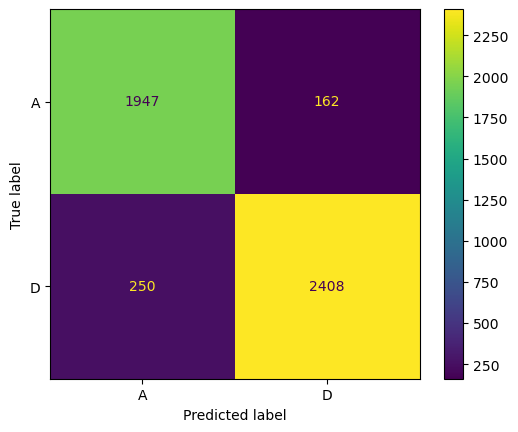

In [370]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

In [371]:
plt.show()

In [372]:
# Som van de diagonale waarden (correcte voorspellingen)
correct_predictions = cm.diagonal().sum()

# Totaal aantal voorspellingen
total_predictions = cm.sum()

# Bereken het succespercentage
accuracy = (correct_predictions / total_predictions) * 100
print(f"Succespercentage: {accuracy:.2f}%")

Succespercentage: 91.36%
